In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import basinhopping
import scipy
import patsy
import os.path as op
import glob
import functools
import moss
import multiprocessing
import ipyparallel as ipp
%matplotlib inline

In [3]:
sns.set_context('talk')
sns.__version__

'0.13.2'

In [5]:
c = ipp.Client()
c.ids

In [13]:
df = pd.read_csv(op.abspath('./rts.csv'))
pet_df = pd.read_csv(op.abspath('./pet_pca.csv'))

df = pd.merge(pet_df,df, how = 'outer', on = ['sub'])

subs = list(set(df['sub']))
len(subs)

77

In [5]:
fontsize = 18
ticksize = fontsize*.8
figy = 4

In [14]:
df = df.reset_index().set_index(['sub','drug']).sort_values(by = ['sub','drug','block','trial'])
df.head()

level_0  Unnamed: 0.1  Unnamed: 0_x  L_caud_body_mean_rac  \
sub drug                                                              
7   brom        0           0.0           0.0              2.710008   
    brom        1           0.0           0.0              2.710008   
    brom        2           0.0           0.0              2.710008   
    brom        3           0.0           0.0              2.710008   
    brom        4           0.0           0.0              2.710008   

          L_DCA_mean_rac  L_DPUT_mean_rac  L_VST_mean_rac  \
sub drug                                                    
7   brom        3.354507         3.999494        2.610669   
    brom        3.354507         3.999494        2.610669   
    brom        3.354507         3.999494        2.610669   
    brom        3.354507         3.999494        2.610669   
    brom        3.354507         3.999494        2.610669   

          R_caud_body_mean_rac  R_DCA_mean_rac  R_DPUT_mean_rac  ...  \
sub drug                                                         ...   
7   brom               2.81783        3.288887         4.037211  ...   
    brom               2.81783        3.288887         4.037211  ...   
    brom               2.81783        3.288887         4.037211  ...   
    brom               2.81783        3.288887         4.037211  ...   
    brom               2.81783        3.288887         4.037211  ...   

          transition_type  transition_type_rewfeature  rew_last_trial  \
sub drug                                                                
7   brom              NaN                         NaN             NaN   
    brom      SameFeature             SameFeature_Rew            0.07   
    brom      SameFeature                 SameFeature            0.06   
    brom      SameFeature                 SameFeature            0.00   
    brom         SameStim                    SameStim            0.00   

          rew_2_trials_back  rew_3_trials_back  rew_last_trial_bin  \
sub drug                                                             
7   brom                NaN                NaN                   0   
    brom                NaN                NaN                   1   
    brom               0.07                NaN                   1   
    brom               0.06               0.07                   0   
    brom               0.00               0.06                   0   

          rew_2_trials_back_bin  rew_3_trials_back_bin  too_early_last_trial  \
sub drug                                                                       
7   brom                      0                      0                 False   
    brom                      0                      0                 False   
    brom                      1                      0                 False   
    brom                      1                      1                 False   
    brom                      0                      1                 False   

          rew_rate  
sub drug            
7   brom       NaN  
    brom       NaN  
    brom       NaN  
    brom       2.0  
    brom       1.0  

[5 rows x 106 columns]

In [15]:
salience_map = {'high':0, 'low':1}
df['salience_bin'] = [salience_map[x] for x in df['salience']]

In [16]:
def state_to_features(state, state_rep):  # state?
    state = str(state)
    if state_rep == 'base':
        return ['baserate']
    
    if state_rep == 'naive': #one feature per state
        return [tuple(state)]
    
    if state_rep == 'feature': 
        features = []
        for n,s in enumerate(state): # n counter; s value
            features.append(str(n) + '_'  + str(s))
        return features
    
    if state_rep == 'combined':
        features = [tuple(state)]
        for n,s in enumerate(state): # n counter; s value
            features.append(str(n) + '_'  + str(s))
        return features
           
state_to_features('12','feature')

['0_1', '1_2']

In [17]:
#It's helpful to run optimization in a continuous parameter space. 
#This function takes a continuous value and maps it into a [0,1] range (or [0,10] for inverse temperature)
def get_parameters(params, model_type):
    
    alpha = scipy.stats.logistic.cdf(params[0])
    beta = params[-4:]

    if model_type == 'basic':
        alpha_neg = alpha
        decay = 1
        collapse = 0
    
    elif model_type == 'two_alphas': #positive and negative learning rates
        alpha_neg = scipy.stats.logistic.cdf(params[1]) 
        decay = 1
        collapse = 0
    
    elif model_type == 'decay': #decay of value of unselected features
        alpha_neg = alpha    
        decay = scipy.stats.logistic.cdf(params[1]) 
        collapse = 0
        
    elif model_type == 'collapse': #exponentially declining learning rate over trials
        alpha_neg = alpha    
        decay = 1
        collapse = scipy.stats.logistic.cdf(params[1]) 
        
    elif model_type == 'two_alphas_decay':
        alpha_neg = scipy.stats.logistic.cdf(params[1]) 
        decay = scipy.stats.logistic.cdf(params[2]) 
        collapse = 0

    
    return alpha, alpha_neg, decay, collapse, beta

get_parameters([0,0,0,0,0,0], 'two_alphas_decay')

(0.5, 0.5, 0.5, 0, [0, 0, 0, 0])

In [18]:
def do_RL(alpha_pos, alpha_neg, decay, collapse, scale_reward, data, state_rep):
    #cycle through trials
    ntrials = data.shape[0]

    W_values = {}
    stim_values = {x:np.zeros(ntrials) for x in data['stim_code'].unique()} #not used in model, just logging stim values for reference
    rpes = []
    values = np.zeros(ntrials) #initialize values
    for n, (state, rew) in enumerate(zip(data['stim_code'], data['rew'])):

        features = state_to_features(state, state_rep) #get features
        for feat in features:

            #if we haven't seen this feature before, initialize to 0
            if feat not in W_values.keys():
                W_values[feat] = 0

            values[n] += W_values[feat] #values are the sume of the feature weights
        
        #log stimulus values (all stimuli, even not present ones)
        for stim in stim_values.keys():
            value = 0
            stim_features = state_to_features(stim, state_rep) #get features
            for feat in stim_features:

                #if we haven't seen this feature before, initialize to 0
                if feat not in W_values.keys():
                    W_values[feat] = 0

                value += W_values[feat] #values are the sume of the feature weights
            stim_values[stim][n] = value
            
        rew = rew* scale_reward
        rew = min(rew,.125*scale_reward) #outlier across all subjects according to IQR
        
        #compute rpe
        delta = rew - values[n]
        rpes.append(delta)
        
        if rew > 0:
            alpha = alpha_pos
        else:
            alpha = alpha_neg

        #potentially collapse learning rate
        alpha = alpha * np.exp(-1*collapse*n)
        
        #rescorla wagner update for stim features
        for feat in features:
            W_values[feat] =  W_values[feat] + alpha*delta
            
        #decay
        other_features = [x for x in W_values.keys() if x not in features]
        for feat in other_features:
            W_values[feat] =  W_values[feat]*decay
    

    return values, stim_values, rpes
# do_RL(.5, 1, 25, df.loc[sub_id, drug].copy().reset_index(), 'feature')

In [19]:
def get_LL(params, data, state_rep, model_type, return_ll = True):

    alpha_feature, alpha_neg, decay, collapse, beta = get_parameters(params, model_type)
    
    scale_reward = 1

    data = data.sort_values(by = ['sub','session','block','trial'])

    values_feature, stim_values, rpes_feature = do_RL(alpha_feature, alpha_neg, decay, collapse, scale_reward, data.copy(), 'feature')


    data['value'] = values_feature
    data['trial'] = scipy.stats.zscore(data['trial'])

    yd,Xd = patsy.dmatrices('rt ~ value + C(rew_last_trial_bin,Sum) + trial + C(block,Sum)',
                            data,NA_action='drop')   

    X = np.asarray(Xd)


    #drop intercept
    X = X[:,1:] 
    X = X - np.mean(X,0)
    y = np.array(list(map(float,np.asarray(yd))))
    y = y - np.mean(y)

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    r2 = scipy.stats.pearsonr(y_hat,y)[0]**2
    sigma = np.std(y - y_hat)
    
    ll = len(y) * np.log(1/(sigma *np.sqrt(2*np.pi))) - (1.0/(2*sigma**2))*(loss**2)

    ll = ll*-1

    if return_ll:
        return ll/len(y)
    else:
        data['ll'] = ll/len(y)
        return data

In [28]:
def get_LL_group(params, state_rep, model_type, df):    
    
    ll = 0
    for sub, session in set(df.index):
        data = df.loc[(sub,session)]
        ll += get_LL(params, data, state_rep, model_type, return_ll = True)
    ll = ll/len(set(df.index))
    
    print(ll)

    return ll
get_LL_group([0,0,0,0,.001,.001,.001,0.001], 'feature', 'two_alphas_decay', df)

In [13]:
def run_group(in_tuple):

    method, params, state_rep, model_type, df = in_tuple

    #minimize
    minimizer_kwargs = {"method": method, 
                        'args':(state_rep,
                                model_type,
                                df)}


    res = basinhopping(get_LL_group, params, minimizer_kwargs=minimizer_kwargs,niter=1)


    alpha, alpha_neg, decay, collapse, beta = get_parameters(res.x,
                                                            model_type)

    out_df = pd.DataFrame({'LL':res.fun,
                           'alpha': alpha,
                           'alpha_neg': alpha_neg,
                           'decay': decay,
                           'collapse': collapse,
                           'beta': beta[0],
                           'beta_last_trial': beta[1],
                           'trial': beta[2],
                            'block':beta[3],
                           'state_rep':state_rep,
                           'model_type':model_type,
                           'method':method},index = [0])
    out_f = op.abspath('./rt_fits/group/' + '_'.join((model_type,state_rep)) + '_Paper.csv')
    out_df.to_csv(out_f,index = False)

    return (res, out_df)


In [14]:
method = 'BFGS'
state_rep = 'feature'
in_tuples = [(method,[0,.001,0.001,.001,0.001],state_rep,'basic',df.copy()),
            (method,[0,0,.001,0.001,.001,0.001],state_rep,'two_alphas',df.copy()),
            (method,[0,0,.001,0.001,.001,0.001],state_rep,'decay',df.copy()),
            (method,[0,0,.001,0.001,.001,0.001],state_rep,'collapse',df.copy()),
            (method,[0,0,0,.001,0.001,.001,0.001],state_rep,'two_alphas_decay',df.copy())]
# run_group(in_tuples[0])

In [15]:
# #fit models in parallel
# dv = c[:]

# dv.block = True

# dv.push(dict(state_to_features = state_to_features,
#             get_LL_group = get_LL_group,
#             get_parameters = get_parameters,
#             do_RL = do_RL,
#             get_LL = get_LL,
#             df = df
#                 ))
# dv.execute("import numpy as np")
# dv.execute("import statsmodels.api as sm")
# dv.execute("import os.path as op")
# dv.execute("import pandas as pd")



# with dv.sync_imports():
#     import os
#     import numpy
#     from scipy.optimize import basinhopping
#     import scipy
#     import patsy
#     import glob    
# #fit lots of models
# dv.map_sync(run_group,in_tuples)

## Load models and compare

In [21]:
fits = glob.glob(op.abspath('./rt_fits/*_Paper.csv'))
res_df = []
for fname in fits:
    f = pd.read_csv(fname)
    model = fname.split('/')[-1].split('.')[0][:-14]
    f['model_type'] = model
    
    ntrials = df.reset_index().dropna(subset = ['rt']).shape[0]
    f['LL'] = ntrials*f['LL']*-1
    
    if f['model_type'][0] == 'basic':
        k = 5
    elif f['model_type'][0] == 'two_alphas_decay':
        k = 7
    else:
        k = 6
    
    f['parameters'] = k
    f['aic'] = k*2 - 2*f['LL']

   
    res_df.append(f.copy())

res_df = pd.concat(res_df)


res_df['aic_rel_basic'] = res_df['aic'] - res_df.loc[res_df.model_type == 'basic','aic']

mod_df = res_df[res_df.model_type !='basic']
res_df

,LL,alpha,alpha_neg,decay,collapse,beta,beta_last_trial,trial,block,state_rep,model_type,method,parameters,aic,aic_rel_basic
0,-141460.932879,0.124740,0.036676,0.973398,0.000000,-2.040101,1.130632,-124.473457,-0.563819,feature,two_alphas_decay,BFGS,7,282935.865758,-9.246423
0,-141467.484625,0.137242,0.137242,1.000000,0.001967,-2.071349,1.348909,-95.121251,-0.790779,feature,collapse,BFGS,6,282946.969250,1.857069
0,-141464.337934,0.096580,0.096580,0.961842,0.000000,-2.114890,1.287384,-127.185059,-0.736812,feature,decay,BFGS,6,282940.675869,-4.436312
0,-141467.556091,0.120636,0.120636,1.000000,0.000000,-2.060300,1.321562,-96.502005,-0.768881,feature,basic,BFGS,5,282945.112181,0.000000
0,-141462.712950,0.144184,0.039662,1.000000,0.000000,-1.999799,1.108498,-110.387131,-0.539766,feature,two_alphas,BFGS,6,282937.425901,-7.686280


/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_98366/1779643312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['model'] = [model_map[x] for x in mod_df['model_type']]
/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_98366/1779643312.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x = 'model',


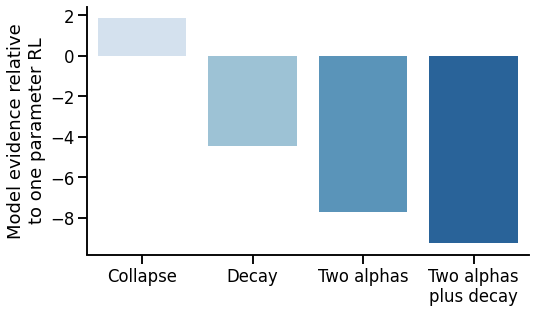

In [23]:
sns.set_context('talk')
model_map = {'collapse':'Collapse',
            'decay':'Decay',
            'two_alphas':'Two alphas',
            'two_alphas_decay': 'Two alphas\nplus decay'}
mod_df['model'] = [model_map[x] for x in mod_df['model_type']]

sns.catplot(x = 'model',
           y = 'aic_rel_basic',
            order = ['Collapse','Decay','Two alphas','Two alphas\nplus decay'],
            palette = 'Blues',
            kind = 'bar',
            aspect = 1.5,
           data = mod_df)
plt.ylabel('Model evidence relative\nto one parameter RL')
plt.xlabel('')
sns.despine()
# plt.savefig('./figs/paper/model_comparison.png', 
#             bbox_inches = 'tight',
#             dpi = 300)

# Analyze Value and Salience RT Effects

In [25]:
#load best fitting parameters
model_type = 'two_alphas_decay'

model_fit = op.abspath('./rt_fits/' + model_type + '_feature_unzscored.csv')
model_fit = pd.read_csv(model_fit)

alpha_feature, alpha_neg, decay, collapse = list(np.array([model_fit['alpha'],model_fit['alpha_neg'],model_fit['decay'],model_fit['collapse'],
         ]).flatten())
beta = list(np.array([model_fit['beta'],model_fit['beta_last_trial'],model_fit['trial'],model_fit['block']]).flatten())


print(alpha_feature, alpha_neg, decay, collapse, beta)

0.1216864597422497 0.0345600079277127 0.9728193145873556 0.0 [-2.0498479935272225, 1.1059824007573449, -127.34663053382374, -0.5511025153927543]


In [29]:
#run through model and insert predictors into dataframe
df = df.sort_values(by = ['sub','drug','block','trial'])
new_df = []
scale_reward = 1


for idx, df_select in df.groupby(level=[0, 1]):
    
    df_select = df_select.copy()
    #get values and rpes for feature model
    values_feature, stim_values, rpes_feature = do_RL(alpha_feature, alpha_neg, decay, collapse, scale_reward, df_select.copy(), 'feature')    
    
    df_select['values'] = values_feature
    df_select['rpes_feature_last_trial'] = [np.NaN] + list(rpes_feature[:-1])
    df_select['rpes_feature'] = rpes_feature
    
    #get values and rpes for stateless control model
    values_stateless, stim_values_stateless, rpes_stateless = do_RL(alpha_feature, alpha_feature, 1, 0, scale_reward, df_select.copy(), 'base')
    df_select['values_stateless'] = values_stateless

    #tack all stimulus values at each time step
    for stim in ['A1_B1','A1_B2','A2_B1','A2_B2']:
        df_select[stim + '_value'] = stim_values[int(stim[1] + stim[4])]
        
        
    #simulate reaction times using value model
    df_select['trial_z'] = scipy.stats.zscore(df_select['trial'])
    yd,Xd = patsy.dmatrices('rt ~ values + C(rew_last_trial_bin,Sum) + trial_z + C(block,Sum)',
                                df_select,NA_action=patsy.NAAction(NA_types=[]))
    X = np.asarray(Xd)

    X = X[:,1:] 
    X = X - np.mean(X,0)
    y_hat = np.dot(X,beta) + np.nanmean(df_select['rt'])

    df_select['Predicted RT'] = y_hat  

    #determine final value for each block
    df_select = df_select.set_index(['block','stimulus'])
    for (block, stim) in set(df_select.index):
        df_select.loc[(block,stim),'last_value'] = df_select.loc[(block,stim +'_value')][-1]
    
    df_select['sub'] = idx[0]
    df_select['drug'] = idx[1]

    new_df.append(df_select.reset_index().copy())
    
new_df = pd.concat(new_df)

#Add useful columns
new_df['Reaction Time'] = new_df['rt_within']

new_df['categorical_rule'] = new_df['salience']

new_df['new_index'] = range(new_df.shape[0])
new_df = new_df.set_index('new_index').reset_index()

new_df['GrandTrial'] = new_df['trial']
new_df.loc[new_df['block'] == 1,'GrandTrial'] = new_df.loc[new_df['block'] == 1,'GrandTrial'].values + 64

salience_map = {'low': 'Low Reward',
               'high': 'High Reward'}
new_df[''] = [salience_map[x] for x in new_df['salience']]
new_df['cat_rule'] = [salience_map[x] for x in new_df['salience']]


In [27]:
#compute individual subject regression coefficients for between-subject analyses
betas_df = []
n = new_df.set_index(['sub','drug'])
for sub, drug in set(n.index):
    
    sub_df = n.loc[sub,drug]
    
    mod = smf.ols("rt ~  1 + C(rew_last_trial_bin,Sum) + C(salience,Sum) + values", data = sub_df).fit()
    
    rt_value = mod.params['values']
    rt_salience = mod.params['C(salience, Sum)[S.high]']


    mod = smf.ols("guess ~ 1 + C(salience,Sum) + values", data = sub_df).fit()
    
    guess_value = mod.params['values']
    guess_salience = mod.params['C(salience, Sum)[S.high]']

    
    betas_df.append(pd.DataFrame({'sub':sub,
                                'drug':drug,
                                'guess_value':guess_value,
                                 'rt_value':rt_value,
                                 'rt_salience':rt_salience,
                                'guess_salience':guess_salience,
                                 'COMT':sub_df['COMT'].values[0],
                                'DRD2':sub_df['DRD2'].values[0],
                                  'VST_rac_split': sub_df['VST_rac'].values[0],
                                  'VST_fmt_split': sub_df['VST_fmt'].values[0],
                                }, index = [0]).copy())
betas_df = pd.concat(betas_df)

#print mean betas
betas_df[['guess_value','guess_salience','rt_value','rt_salience']].mean()

guess_value       -10.696250
guess_salience     21.213073
rt_value         -159.609725
rt_salience        -0.313094
dtype: float64

In [19]:
betas_df.to_csv('./betas_df.csv')
new_df.to_csv('./new_df.csv')

In [20]:
new_df

,new_index,block,stimulus,level_0,Unnamed: 0_x,Unnamed: 0.1,L_caud_body_mean_rac,L_DCA_mean_rac,L_DPUT_mean_rac,L_VST_mean_rac,...,trial_z,Predicted RT,last_value,sub,drug,Reaction Time,categorical_rule,GrandTrial,,cat_rule
0,0,0,A1_B2,0,0.0,0.0,2.710008,3.354507,3.999494,2.610669,...,-1.705196,236.395708,0.049075,7,brom,214.836380,high,1,High Reward,High Reward
1,1,0,A1_B1,1,0.0,0.0,2.710008,3.354507,3.999494,2.610669,...,-1.651062,239.380826,0.052059,7,brom,216.836380,high,2,High Reward,High Reward
2,2,0,A2_B1,2,0.0,0.0,2.710008,3.354507,3.999494,2.610669,...,-1.596929,239.637956,0.024846,7,brom,232.836380,low,3,Low Reward,Low Reward
3,3,0,A2_B2,3,0.0,0.0,2.710008,3.354507,3.999494,2.610669,...,-1.542796,235.307202,0.021862,7,brom,210.836380,low,4,Low Reward,Low Reward
4,4,0,A2_B2,4,0.0,0.0,2.710008,3.354507,3.999494,2.610669,...,-1.488663,235.346421,0.021862,7,brom,237.836380,low,5,Low Reward,Low Reward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29307,29307,1,A1_B1,19707,51.0,51.0,2.232947,3.012305,3.980082,2.606155,...,1.488663,213.233277,0.038069,754,tolc,231.441171,high,124,High Reward,High Reward
29308,29308,1,A2_B2,19708,51.0,51.0,2.232947,3.012305,3.980082,2.606155,...,1.542796,216.223628,0.014595,754,tolc,148.441171,low,125,Low Reward,Low Reward
29309,29309,1,A1_B1,19709,51.0,51.0,2.232947,3.012305,3.980082,2.606155,...,1.596929,208.945495,0.038069,754,tolc,176.441171,high,126,High Reward,High Reward
29310,29310,1,A2_B2,19710,51.0,51.0,2.232947,3.012305,3.980082,2.606155,...,1.651062,212.272455,0.014595,754,tolc,198.441171,low,127,Low Reward,Low Reward


## Parameter recovery study

In [32]:
model_fit

,LL,alpha,alpha_neg,decay,collapse,beta,beta_last_trial,trial,block,state_rep,model_type,method
0,5.009769,0.121686,0.03456,0.972819,0,-2.049848,1.105982,-127.346631,-0.551103,feature,two_alphas_decay,BFGS


In [23]:
def run_parameter_recovery(in_tuple):
    method, params, state_rep, model_type, iteration, df = in_tuple

    #minimize
    minimizer_kwargs = {"method": method, 
                    'args':(state_rep,
                            model_type,
                            df)}


    res_noise = basinhopping(get_LL_group, params, minimizer_kwargs=minimizer_kwargs,niter=1)
    
    alpha, alpha_neg, decay, collapse, beta = get_parameters(res_noise.x,
                                                                model_type)

    out_df = pd.DataFrame({'LL':res_noise.fun,
                           'alpha': alpha,
                           'alpha_neg': alpha_neg,
                           'decay': decay,
                           'collapse': collapse,
                           'beta': beta[0],
                           'beta_last_trial': beta[1],
                           'trial': beta[2],
                            'block':beta[3],
                           'state_rep':state_rep,
                           'model_type':model_type,
                           'method':method},index = [0])
    out_f = op.abspath('./rt_fits/parameter_recovery/' + '_'.join((model_type,state_rep,'iter_' + str(iteration))) + '_Paper.csv')
    out_df.to_csv(out_f,index = False)
    
    return res_noise,out_df

    

In [25]:
iterations = 500

in_tuples = []
for i in range(100,iterations):
    fit_df = new_df.copy()

    #calculate noise std
    sigma = np.std(fit_df['rt'] - fit_df['Predicted RT'])

    #add noise to data
    noise = np.random.normal(0,sigma,len(fit_df['Predicted RT']))
    fit_df['predicted_rt_noise'] = np.array(fit_df['Predicted RT']) + np.array(noise)

    #remove predictions for trials with no real RT
    fit_df.loc[fit_df['rt'].isnull(),'predicted_rt_noise'] = np.NaN

    ##put in simulated RTs
    fit_df['rt'] = fit_df['predicted_rt_noise']

    fit_df = fit_df.set_index(['sub','drug']).sort_values(by = ['sub','drug','block','trial'])

    in_tuple = ('BFGS',[0,0,0,.001,0.001,.001,0.001],'feature','two_alphas_decay',i, fit_df.copy())
    in_tuples.append(in_tuple)

In [26]:
#fit models in parallel
dv = c[:]

dv.block = True

dv.push(dict(state_to_features = state_to_features,
            get_LL_group = get_LL_group,
            get_parameters = get_parameters,
            do_RL = do_RL,
            get_LL = get_LL,
                ))
dv.execute("import numpy as np")
dv.execute("import statsmodels.api as sm")
dv.execute("import os.path as op")
dv.execute("import pandas as pd")



with dv.sync_imports():
    import os
    import numpy
    from scipy.optimize import basinhopping
    import scipy
    import patsy
    import glob    
#fit lots of models
dv.map_sync(run_parameter_recovery,in_tuples)

importing os on engine(s)
importing numpy on engine(s)
importing basinhopping from scipy.optimize on engine(s)
importing scipy on engine(s)
importing patsy on engine(s)
importing glob on engine(s)


[(                        fun: 5.122437974324715
   lowest_optimization_result:       fun: 5.122437974324715
   hess_inv: array([[ 4.94457390e+01,  2.65435264e+00,  3.47387469e+00,
          -1.09927845e+02, -2.26775422e+02, -3.48266410e-01,
          -1.23050730e+02],
         [ 2.65435264e+00,  1.14543237e+00,  1.90334554e-01,
          -6.02297186e+00, -1.24250766e+01, -1.90816451e-02,
          -6.74197758e+00],
         [ 3.47387469e+00,  1.90334554e-01,  1.24909921e+00,
          -7.88254059e+00, -1.62612716e+01, -2.49729118e-02,
          -8.82353683e+00],
         [-1.09927845e+02, -6.02297186e+00, -7.88254059e+00,
           2.50436403e+02,  5.14574318e+02,  7.90248268e-01,
           2.79213438e+02],
         [-2.26775422e+02, -1.24250766e+01, -1.62612716e+01,
           5.14574318e+02,  1.06254003e+03,  1.63024124e+00,
           5.76002791e+02],
         [-3.48266410e-01, -1.90816451e-02, -2.49729118e-02,
           7.90248268e-01,  1.63024124e+00,  1.00250360e+00,
        

In [28]:
recovered_files = glob.glob('./rt_fits/parameter_recovery/' + '_'.join(('two_alphas_decay',
                                                                        'feature',
                                                                      'iter_*_Paper.csv')))
recovered_params = []
for r in recovered_files:
    
    iteration = r.split('/')[-1].split('_')[-2]
    
    r_df = pd.read_csv(r)
    r_df['iteration'] = iteration
    
    recovered_params.append(r_df.copy())
recovered_params = pd.concat(recovered_params)
recovered_params.shape

(500, 13)

In [29]:
recovered_params.median()

/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_1824/582700871.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  recovered_params.median()


LL                   5.119778
alpha                0.122862
alpha_neg            0.036171
decay                0.974920
collapse             0.000000
beta                -2.032589
beta_last_trial      1.105013
trial             -127.089874
block               -0.579751
iteration          249.500000
dtype: float64

In [30]:
recovered_params.quantile(.05)

LL                   5.113258
alpha                0.047011
alpha_neg            0.004835
decay                0.921220
collapse             0.000000
beta                -2.450073
beta_last_trial      0.534447
trial             -228.949144
block               -1.064065
Name: 0.05, dtype: float64

In [31]:
recovered_params.quantile(.95)

LL                  5.126194
alpha               0.192462
alpha_neg           0.109544
decay               0.999460
collapse            0.000000
beta               -1.630741
beta_last_trial     1.557372
trial             -91.080819
block              -0.062434
Name: 0.95, dtype: float64